In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np  # For linear algebra operations
import pandas as pd  # For data processing and CSV file I/O
import matplotlib.pyplot as plt  # For data visualization
import matplotlib.image as img  # For handling image data
from sklearn.model_selection import train_test_split  # For splitting data
from tqdm import tqdm  # For displaying progress bars
import cv2 as cv  # OpenCV for image processing
import torch.nn as nn  # Neural network module in PyTorch
import os  # For file system operations

In [ ]:
# Define the location of the dataset
data_loc = "./AttentionCaxtonModel/data/"

# Print the current working directory
print(os.getcwd())

# Load training and test data labels from CSV files
train_labels = pd.read_csv(data_loc + 'train.csv')
test_labels = pd.read_csv(data_loc + 'test.csv')

/ibex/user/abduam0d/3D-Printer-Error-Detection


In [ ]:
# Display the first few rows of the test dataset
test_labels

,img_path,printer_id,print_id
0,101/1678578332/1678578538.704966.jpg,101,1678578332
1,101/1678578332/1678578539.108019.jpg,101,1678578332
2,101/1678578332/1678578539.512872.jpg,101,1678578332
3,101/1678578332/1678578539.916711.jpg,101,1678578332
4,101/1678578332/1678578540.329089.jpg,101,1678578332
...,...,...,...
25274,022/1672795514/1672796229.177132.jpg,22,1672795514
25275,022/1672795514/1672796230.177629.jpg,22,1672795514
25276,022/1672795514/1672796231.187994.jpg,22,1672795514
25277,022/1672795514/1672796232.19111.jpg,22,1672795514


In [ ]:
# Display the first few rows of the training dataset
train_labels

,img_path,printer_id,print_id,has_under_extrusion
0,101/1678589738/1678589914.060332.jpg,101,1678589738,1
1,101/1678589738/1678589914.462857.jpg,101,1678589738,1
2,101/1678589738/1678589914.875075.jpg,101,1678589738,1
3,101/1678589738/1678589915.284495.jpg,101,1678589738,1
4,101/1678589738/1678589915.700486.jpg,101,1678589738,1
...,...,...,...,...
81055,022/1672857603/1672858113.083624.jpg,22,1672857603,1
81056,022/1672857603/1672858114.101455.jpg,22,1672857603,1
81057,022/1672857603/1672858115.107314.jpg,22,1672857603,1
81058,022/1672857603/1672858116.11023.jpg,22,1672857603,1


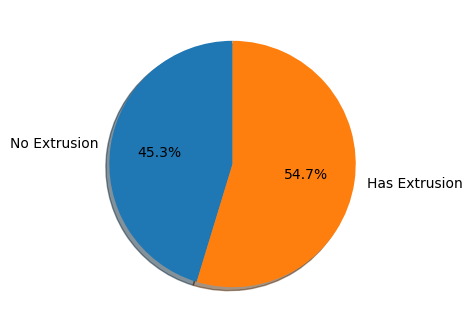

has_under_extrusion
1    44342
0    36718
Name: count, dtype: int64


In [ ]:
# Labels for the pie chart visualization
label = 'No Extrusion', 'Has Extrusion'

# Plotting a pie chart of the distribution of labels in the training set
plt.figure(figsize=(4, 4))
plt.pie(train_labels.groupby('has_under_extrusion').size(), labels=label, autopct='%1.1f%%', shadow=True, startangle=90)
plt.show()

# Print the count of each label in the training dataset
print(train_labels['has_under_extrusion'].value_counts())

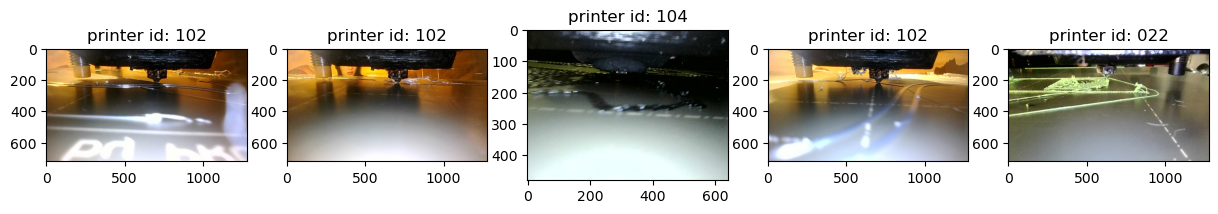

In [ ]:
# Directory where images are stored
image_loc = './' + "images/"

# Visualize examples of images with under extrusion
fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for i, img_path in enumerate(np.random.choice(train_labels[train_labels['has_under_extrusion'] == 1]['img_path'].values, 5)):
    ax[i].imshow(img.imread(image_loc + img_path))
    ax[i].set_title("printer id: {}".format(img_path.split('/')[0]))

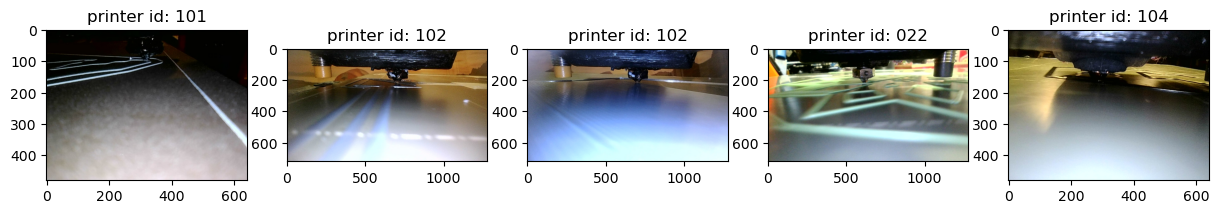

In [ ]:
# Visualize examples of images without under extrusion
fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for i, img_path in enumerate(np.random.choice(train_labels[train_labels['has_under_extrusion'] == 0]['img_path'].values, 5)):
    ax[i].imshow(img.imread(image_loc + img_path))
    ax[i].set_title("printer id: {}".format(img_path.split('/')[0]))

In [ ]:
# Check if CUDA (GPU) is available and set the device accordingly
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device  # Display the current device being used

device(type='cuda', index=0)

In [ ]:
# Dataset class for handling the printer image data
class PrinterDataset(torch.utils.data.Dataset):
    def __init__(self, data, path, image_loc, transform=None):
        super().__init__()
        self.data = data  # Data labels
        self.img_path = path  # Paths to the images
        self.transform = transform  # Transformation applied to images
        self.image_loc = image_loc  # Base directory of images

    def __len__(self):
        # Return the size of the dataset
        return len(self.data)

    def __getitem__(self, index):
        # Fetch the label and image for a given index
        label = torch.tensor(self.data.values[index]).long().to(device)
        img_path = self.img_path.values[index]
        image = img.imread(self.image_loc + img_path)
        if self.transform is not None:
            image = self.transform(image)
        image = image.float().to(device)
        return image, label, img_path

In [ ]:
# Display the shape of example images from different printers
for i in train_labels['printer_id'].unique():
    path = train_labels[train_labels['printer_id'] == i]['img_path'].values[0]
    print(img.imread(image_loc + path).shape)

(480, 640, 3)
(720, 1280, 3)
(1080, 1920, 3)
(480, 640, 3)
(720, 1280, 3)


In [ ]:
# Hyperparameters for the training process
num_epochs = 5  # Number of training epochs
num_classes = 2  # Binary classification (Has extrusion or not)
batch_size = 50  # Batch size for training
learning_rate = 0.001  # Learning rate for optimizer
image_resize = (224, 224)  # Resize images to 224x224

In [ ]:
# Define transformations to apply to the images
image_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(image_resize),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5)
])

# Create datasets and data loaders for training, validation, and testing
train_data = PrinterDataset(train_labels['has_under_extrusion'], train_labels['img_path'], image_loc, image_transform)
test_data = PrinterDataset(pd.DataFrame(np.ones(len(test_labels))), test_labels['img_path'], image_loc, image_transform)

train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False, num_workers=0)

In [ ]:
# Fetch a batch of training images and labels for testing
train_images, train_labels, _ = next(iter(train_loader))

In [ ]:
# Function to train the model
def train_model(model, train_loader, num_epochs, scheduler=None):
    train_losses = []  # Keep track of training losses
    min_loss = float('inf')  # Initialize minimum loss

    for epoch in range(1, num_epochs + 1):
        train_loss = 0.0  # Reset the training loss for each epoch
        model.train()  # Set the model to training mode

        for data, target, _ in tqdm(train_loader):
            optimizer.zero_grad()  # Clear the gradients
            output = model(data)  # Forward pass
            loss = criterion(output, target)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update model parameters
            train_loss += loss.item() * data.size(0)  # Accumulate training loss

        if train_loss < min_loss:
            min_loss = train_loss
            torch.save(model.state_dict(), 'model.ckpt')  # Save the best model

        train_loss = train_loss / len(train_loader.sampler)  # Compute average loss
        train_losses.append(train_loss)  # Store training loss
        scheduler.step(train_loss)  # Update learning rate if scheduler is used

        print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))  # Display training stats

    return train_losses  # Return the list of training losses

In [ ]:
# Convolutional Neural Network (CNN) model definition
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Define the layers of the CNN
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()  # Dropout layer for regularization
        self.fc1 = nn.Linear(720, 1024)  # Fully connected layer
        self.fc2 = nn.Linear(1024, 2)  # Output layer for binary classification

    def forward(self, x):
        print(x.shape)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))  # Convolution + ReLU + Max pooling
        print(x.shape)
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))  # Convolution + Dropout + Max pooling
        print(x.shape)
        x = x.view(x.shape[0], -1)  # Flatten the tensor
        print(x.shape)
        x = F.relu(self.fc1(x))  # Fully connected layer + ReLU
        print(x.shape)
        x = F.dropout(x, training=self.training)  # Apply dropout during training
        print(x.shape)
        x = self.fc2(x)  # Final output layer
        return x

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, input_channels, output_channels, stride=1):
        super(ResidualBlock, self).__init__()
        # Initialize the input and output channel sizes and stride
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.stride = stride
        # First batch normalization and activation layer
        self.bn1 = nn.BatchNorm2d(input_channels)
        self.relu = nn.ReLU(inplace=True)
        # First convolution layer (1x1 convolution to reduce dimensions)
        self.conv1 = nn.Conv2d(input_channels, output_channels // 4, 1, 1, bias=False)
        # Second batch normalization and activation layer
        self.bn2 = nn.BatchNorm2d(output_channels // 4)
        self.relu = nn.ReLU(inplace=True)
        # Second convolution layer (3x3 convolution with stride for feature extraction)
        self.conv2 = nn.Conv2d(output_channels // 4, output_channels // 4, 3, stride, padding=1, bias=False)
        # Third batch normalization and activation layer
        self.bn3 = nn.BatchNorm2d(output_channels // 4)
        self.relu = nn.ReLU(inplace=True)
        # Third convolution layer (1x1 convolution to expand dimensions)
        self.conv3 = nn.Conv2d(output_channels // 4, output_channels, 1, 1, bias=False)
        # Optional convolution to match the dimensions of input and output if necessary
        self.conv4 = nn.Conv2d(input_channels, output_channels, 1, stride, bias=False)
    def forward(self, x):
        # Save the input tensor as residual (shortcut connection)
        residual = x
        # Apply first batch normalization and activation
        out = self.bn1(x)
        out1 = self.relu(out)
        # Apply the first convolution layer
        out = self.conv1(out1)
        # Apply the second batch normalization and activation
        out = self.bn2(out)
        out = self.relu(out)
        # Apply the second convolution layer
        out = self.conv2(out)
        # Apply the third batch normalization and activation
        out = self.bn3(out)
        out = self.relu(out)
        # Apply the third convolution layer
        out = self.conv3(out)
        # If the input and output dimensions do not match, use conv4 to adjust residual dimensions
        if (self.input_channels != self.output_channels) or (self.stride != 1):
            residual = self.conv4(out1)
        # Add the residual (shortcut) to the output
        out += residual
        # Return the final output
        return out


In [ ]:
class AttentionModule_stage1(nn.Module):
    # The input image size is 56x56
    def __init__(self, in_channels, out_channels, size1=(56, 56), size2=(28, 28), size3=(14, 14)):
        super(AttentionModule_stage1, self).__init__()
        
        # Initial Residual Block that processes the input
        self.first_residual_blocks = ResidualBlock(in_channels, out_channels)
        
        # Trunk branch, containing two residual blocks for the main feature processing
        self.trunk_branches = nn.Sequential(
            ResidualBlock(in_channels, out_channels),
            ResidualBlock(in_channels, out_channels)
        )
        
        # Max pooling for down-sampling in the attention branch
        self.mpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # First set of residual blocks in the soft attention mechanism
        self.softmax1_blocks = ResidualBlock(in_channels, out_channels)
        
        # Skip connection for attention branch
        self.skip1_connection_residual_block = ResidualBlock(in_channels, out_channels)
        
        # Second max pooling for further down-sampling
        self.mpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Second set of residual blocks in the soft attention mechanism
        self.softmax2_blocks = ResidualBlock(in_channels, out_channels)
        
        # Second skip connection for attention branch
        self.skip2_connection_residual_block = ResidualBlock(in_channels, out_channels)
        
        # Third max pooling for even further down-sampling
        self.mpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Third set of residual blocks in the soft attention mechanism
        self.softmax3_blocks = nn.Sequential(
            ResidualBlock(in_channels, out_channels),
            ResidualBlock(in_channels, out_channels)
        )
        
        # Upsampling from the third down-sampled level to the second
        self.interpolation3 = nn.UpsamplingBilinear2d(size=size3)
        
        # Fourth set of residual blocks after upsampling
        self.softmax4_blocks = ResidualBlock(in_channels, out_channels)
        
        # Upsampling from the second down-sampled level to the first
        self.interpolation2 = nn.UpsamplingBilinear2d(size=size2)
        
        # Fifth set of residual blocks after upsampling
        self.softmax5_blocks = ResidualBlock(in_channels, out_channels)
        
        # Upsampling from the first down-sampled level to the original input size
        self.interpolation1 = nn.UpsamplingBilinear2d(size=size1)
        
        # Final layer for soft attention mechanism with normalization, activation, and sigmoid
        self.softmax6_blocks = nn.Sequential(
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.Sigmoid()
        )
        
        # Final residual blocks after applying attention
        self.last_blocks = ResidualBlock(in_channels, out_channels)

    def forward(self, x):
        # Apply the first residual block
        x = self.first_residual_blocks(x)
        
        # Process the input through the trunk branch
        out_trunk = self.trunk_branches(x)
        
        # Down-sample with the first max pool and apply the first attention block
        out_mpool1 = self.mpool1(x)
        out_softmax1 = self.softmax1_blocks(out_mpool1)
        
        # Apply the first skip connection residual block
        out_skip1_connection = self.skip1_connection_residual_block(out_softmax1)
        
        # Down-sample again with the second max pool and apply the second attention block
        out_mpool2 = self.mpool2(out_softmax1)
        out_softmax2 = self.softmax2_blocks(out_mpool2)
        
        # Apply the second skip connection residual block
        out_skip2_connection = self.skip2_connection_residual_block(out_softmax2)
        
        # Down-sample a third time and apply the third set of attention blocks
        out_mpool3 = self.mpool3(out_softmax2)
        out_softmax3 = self.softmax3_blocks(out_mpool3)
        
        # Upsample from the third to the second level and combine features
        out_interp3 = self.interpolation3(out_softmax3) + out_softmax2
        out = out_interp3 + out_skip2_connection
        
        # Apply the fourth set of attention blocks
        out_softmax4 = self.softmax4_blocks(out)
        
        # Upsample from the second to the first level and combine features
        out_interp2 = self.interpolation2(out_softmax4) + out_softmax1
        out = out_interp2 + out_skip1_connection
        
        # Apply the fifth set of attention blocks
        out_softmax5 = self.softmax5_blocks(out)
        
        # Upsample to the original size and combine features
        out_interp1 = self.interpolation1(out_softmax5) + out_trunk
        
        # Apply the final attention blocks
        out_softmax6 = self.softmax6_blocks(out_interp1)
        
        # Combine the soft attention output with the trunk output
        out = (1 + out_softmax6) * out_trunk
        
        # Apply the final residual block
        out_last = self.last_blocks(out)

        return out_last


class AttentionModule_stage2(nn.Module):
    # Input image size is 28x28
    def __init__(self, in_channels, out_channels, size1=(28, 28), size2=(14, 14)):
        super(AttentionModule_stage2, self).__init__()
        
        # Similar to AttentionModule_stage1, but adapted for a smaller input size
        self.first_residual_blocks = ResidualBlock(in_channels, out_channels)
        self.trunk_branches = nn.Sequential(
            ResidualBlock(in_channels, out_channels),
            ResidualBlock(in_channels, out_channels)
        )
        self.mpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.softmax1_blocks = ResidualBlock(in_channels, out_channels)
        self.skip1_connection_residual_block = ResidualBlock(in_channels, out_channels)
        self.mpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.softmax2_blocks = nn.Sequential(
            ResidualBlock(in_channels, out_channels),
            ResidualBlock(in_channels, out_channels)
        )
        self.interpolation2 = nn.UpsamplingBilinear2d(size=size2)
        self.softmax3_blocks = ResidualBlock(in_channels, out_channels)
        self.interpolation1 = nn.UpsamplingBilinear2d(size=size1)
        self.softmax4_blocks = nn.Sequential(
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.Sigmoid()
        )
        self.last_blocks = ResidualBlock(in_channels, out_channels)

    def forward(self, x):
        x = self.first_residual_blocks(x)
        out_trunk = self.trunk_branches(x)
        out_mpool1 = self.mpool1(x)
        out_softmax1 = self.softmax1_blocks(out_mpool1)
        out_skip1_connection = self.skip1_connection_residual_block(out_softmax1)
        out_mpool2 = self.mpool2(out_softmax1)
        out_softmax2 = self.softmax2_blocks(out_mpool2)
        out_interp2 = self.interpolation2(out_softmax2) + out_softmax1
        out = out_interp2 + out_skip1_connection
        out_softmax3 = self.softmax3_blocks(out)
        out_interp1 = self.interpolation1(out_softmax3) + out_trunk
        out_softmax4 = self.softmax4_blocks(out_interp1)
        out = (1 + out_softmax4) * out_trunk
        out_last = self.last_blocks(out)

        return out_last


class AttentionModule_stage3(nn.Module):
    # Input image size is 14x14
    def __init__(self, in_channels, out_channels, size1=(14, 14)):
        super(AttentionModule_stage3, self).__init__()
        
        # Similar to the previous stages but with fewer down-sampling levels
        self.first_residual_blocks = ResidualBlock(in_channels, out_channels)
        self.trunk_branches = nn.Sequential(
            ResidualBlock(in_channels, out_channels),
            ResidualBlock(in_channels, out_channels)
        )
        self.mpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.softmax1_blocks = nn.Sequential(
            ResidualBlock(in_channels, out_channels),
            ResidualBlock(in_channels, out_channels)
        )
        self.interpolation1 = nn.UpsamplingBilinear2d(size=size1)
        self.softmax2_blocks = nn.Sequential(
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.Sigmoid()
        )
        self.last_blocks = ResidualBlock(in_channels, out_channels)

    def forward(self, x):
        x = self.first_residual_blocks(x)
        out_trunk = self.trunk_branches(x)
        out_mpool1 = self.mpool1(x)
        out_softmax1 = self.softmax1_blocks(out_mpool1)
        out_interp1 = self.interpolation1(out_softmax1) + out_trunk
        out_softmax2 = self.softmax2_blocks(out_interp1)
        out = (1 + out_softmax2) * out_trunk
        out_last = self.last_blocks(out)

        return out_last


In [ ]:
class ResidualAttentionModel_56(nn.Module):
    # This model is designed for input image size 224x224
    def __init__(self):
        super(ResidualAttentionModel_56, self).__init__()
        # Initial convolutional layer with a 7x7 kernel, stride of 2, and padding of 3
        # This reduces the spatial dimensions of the input image by half
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        # Max Pooling layer to further reduce spatial dimensions
        self.mpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # First set of residual blocks
        # Input: 64 channels, Output: 256 channels
        self.residual_block1 = ResidualBlock(64, 256)
        # First attention module for input size 56x56
        self.attention_module1 = AttentionModule_stage1(256, 256)
        # Second set of residual blocks with down-sampling
        # Input: 256 channels, Output: 512 channels (with a stride of 2 for down-sampling)
        self.residual_block2 = ResidualBlock(256, 512, 2)
        # Second attention module for input size 28x28
        self.attention_module2 = AttentionModule_stage2(512, 512)
        # Third set of residual blocks with down-sampling
        # Input: 512 channels, Output: 1024 channels (with a stride of 2 for down-sampling)
        self.residual_block3 = ResidualBlock(512, 1024, 2)
        # Third attention module for input size 14x14
        self.attention_module3 = AttentionModule_stage3(1024, 1024)
        # Fourth set of residual blocks with down-sampling
        # Input: 1024 channels, Output: 2048 channels (with a stride of 2 for down-sampling)
        self.residual_block4 = ResidualBlock(1024, 2048, 2)
        # Additional residual blocks for deeper network processing
        self.residual_block5 = ResidualBlock(2048, 2048)
        self.residual_block6 = ResidualBlock(2048, 2048)
        # Final pooling and normalization before classification
        # Using an average pooling layer to reduce the feature map to 1x1
        self.mpool2 = nn.Sequential(
            nn.BatchNorm2d(2048),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=7, stride=1)
        )
        # Fully connected layer for classification
        # Mapping from the feature space (2048) to 10 output classes
        self.fc = nn.Linear(2048, 10)
    def forward(self, x):
        # Forward pass through the initial convolutional layer
        out = self.conv1(x)
        # Down-sampling with the first max pooling layer
        out = self.mpool1(out)
        # Pass through the first residual block
        out = self.residual_block1(out)
        # Apply the first attention module
        out = self.attention_module1(out)
        # Down-sample and pass through the second residual block
        out = self.residual_block2(out)
        # Apply the second attention module
        out = self.attention_module2(out)
        # Down-sample and pass through the third residual block
        out = self.residual_block3(out)
        # Apply the third attention module
        out = self.attention_module3(out)
        # Down-sample and pass through the fourth residual block
        out = self.residual_block4(out)
        # Additional residual blocks without down-sampling
        out = self.residual_block5(out)
        out = self.residual_block6(out)
        # Apply final pooling and normalization
        out = self.mpool2(out)
        # Flatten the tensor for the fully connected layer
        out = out.view(out.size(0), -1)
        # Fully connected layer for final classification
        out = self.fc(out)
        return out

In [22]:

# epochs = 9
# batch_size = 32
# learning_rate = 0.001
# model = ResidualAttentionModel_56()
# print(model)

In [23]:
# %%time
# model = ResidualAttentionModel_56().to(device)
# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)
# train_losses = train_model(model, train_loader, epochs)

In [ ]:
# Initialize the model using the ResidualAttentionModel_56 class
model = ResidualAttentionModel_56()
# Load the pre-trained model weights from a checkpoint file ('model.ckpt')
# This step assumes the model was previously trained and saved
model.load_state_dict(torch.load('model.ckpt'))
# Move the model to the appropriate device (CPU or GPU) for training or inference
model = model.to(device)
# Set training parameters
epochs = 3                  # Number of epochs to train the model
batch_size = 32             # Number of samples per batch during training
learning_rate = 0.0001      # Initial learning rate for the optimizer
# Define the loss function
# CrossEntropyLoss is used for multi-class classification problems
criterion = torch.nn.CrossEntropyLoss()
# Use Adam optimizer for training
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# Define a learning rate scheduler
# ReduceLROnPlateau decreases the learning rate by a factor of 0.1 if the loss
# does not improve for a specified number of epochs (patience = 10)
# The 'verbose=True' argument makes it print updates when it reduces the learning rate
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=10, verbose=True
)
# Start training the model
# train_model is a custom function that takes in the model,
# training data loader, number of epochs, and the learning rate scheduler
# It returns the training losses over the epochs
train_losses = train_model(model, train_loader, epochs, scheduler)


/ibex/user/abduam0d/conda-environments/temp_env/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
100%|██████████████████████████████████████████████████████████████████████████| 1622/1622 [22:40<00:00,  1.19it/s]


Epoch: 1 	Training Loss: 0.001688


100%|██████████████████████████████████████████████████████████████████████████| 1622/1622 [22:34<00:00,  1.20it/s]


Epoch: 2 	Training Loss: 0.000814


100%|██████████████████████████████████████████████████████████████████████████| 1622/1622 [22:34<00:00,  1.20it/s]


Epoch: 3 	Training Loss: 0.000409


In [25]:
# %%time
# model = CNN().to(device)
# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)
# train_losses, valid_losses = train_model(model, train_loader, None)

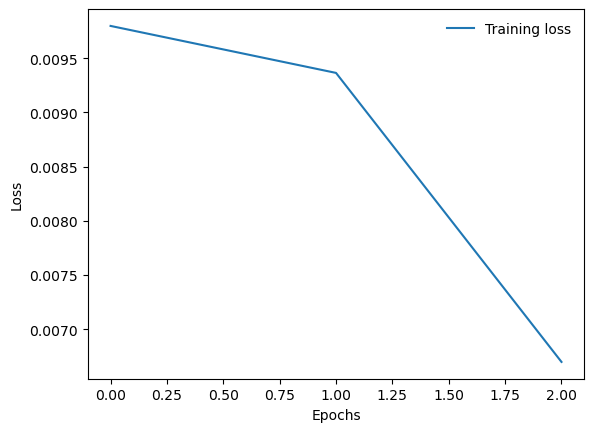

In [ ]:
import matplotlib.pyplot as plt
# Plot the training loss over epochs
# `train_losses` is a list that contains the training loss values for each epoch
plt.plot(train_losses, label='Training loss')
# Uncomment the following line if you have validation losses to plot
# `valid_losses` would contain the validation loss values for each epoch, useful for tracking overfitting
# plt.plot(valid_losses, label='Validation loss')
# Label the x-axis with the string "Epochs", which represents the number of training epochs
plt.xlabel("Epochs")
# Label the y-axis with the string "Loss", which represents the loss values during training
plt.ylabel("Loss")
# Add a legend to the plot that explains the lines (Training loss and Validation loss)
# `frameon=False` removes the frame around the legend for a cleaner appearance
plt.legend(frameon=False)
# Show the plot
plt.show()


In [ ]:
# Set the model to evaluation mode, which disables dropout layers and batch normalization updates
model.eval()

# Save the model's state_dict (weights) to a file called 'model.ckpt'
# This is useful for saving the trained model and reloading it later for inference or continued training
torch.save(model.state_dict(), 'model.ckpt')

# Initialize an empty DataFrame to store results (image paths and predictions)
res = pd.DataFrame()

# Disable gradient computation as we're in inference mode (to save memory and computation)
# This is achieved with `torch.no_grad()`
with torch.no_grad():
    correct = 0  # Variable to track correct predictions (though not used here)
    total = 0  # Variable to track total number of samples (not used here)
    
    # Loop over the test data loader (`test_loader`)
    # `tqdm` provides a progress bar for the loop
    for images, _, path in tqdm(test_loader):
        # Move the images to the specified device (GPU or CPU)
        images = images.to(device)
        
        # Get model outputs (predictions)
        outputs = model(images)
        
        # Get the predicted class labels by finding the index of the max output value for each image
        _, predicted = torch.max(outputs.data, 1)
        
        # Concatenate the current batch's results to the result DataFrame
        # `path` contains the file paths of the images, `predicted` contains the predicted class labels
        # Each row in the DataFrame will contain the image path and its predicted label
        res = pd.concat((res, pd.DataFrame([[p, int(l.item())] for p, l in zip(path, predicted)], columns=['img_path', 'has_under_extrusion'])))

# Save the DataFrame containing the image paths and their corresponding predicted labels to a CSV file
# This will be the output file used for submission or further analysis
res.to_csv('submission.csv', index=False)


100%|████████████████████████████████████████████████████████████████████████████| 506/506 [05:09<00:00,  1.63it/s]
